# Class 06 - Outline

[0 - What is OpenMP](#zero)  
[1 - OpenMP Hello World](#one)  
[2 - Fork Join Parallelism](#two)  
[3 - Synchronization](#three)  
[4 - Work and Data Sharing Clauses](#four)  
[5 - Tasks with OpenMP](#five)  
[6 - Conclusions](#six)  

In [1]:
from IPython.display import Image

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import re
from math import *

%matplotlib inline

In [88]:
%alias clean rm -f *.c *.exe *.py *.pyc *.s .*f95 *.o *.fo *log *.h *.cc *.mod

In [4]:
%clean

Remember that you may to load modules or set aliases and paths in Makefiles (see below) to the right location if you are not using a system installed gcc (or modules)

%alias gcc /usr/local/gcc-7.3.0/bin/gcc -static -L/usr/local/gcc-7.3.0/lib64 -I/usr/local/gcc-7.3.0/include 
%alias g++ /usr/local/gcc-7.3.0/bin/g++ -static -L/usr/local/gcc-7.3.0/lib64 -I/usr/local/gcc-7.3.0/include 
%alias gfortran /usr/local/gcc-7.3.0/bin/gfortran -static -L/usr/local/gcc-7.3.0/lib64 -I/usr/local/gcc-7.3.0/include 

In [5]:
%alias

Total number of aliases: 13


[('cat', 'cat'),
 ('clean',
  'rm -f *.c *.exe *.py *.pyc *.s .*f95 *.o *.fo *log *.h *.cc *.mod'),
 ('cp', 'cp'),
 ('ldir', 'ls -F -o --color %l | grep /$'),
 ('lf', 'ls -F -o --color %l | grep ^-'),
 ('lk', 'ls -F -o --color %l | grep ^l'),
 ('ll', 'ls -F -o --color'),
 ('ls', 'ls -F --color'),
 ('lx', 'ls -F -o --color %l | grep ^-..x'),
 ('mkdir', 'mkdir'),
 ('mv', 'mv'),
 ('rm', 'rm'),
 ('rmdir', 'rmdir')]

<a id="zero"></a>

# 0 - What is a thread

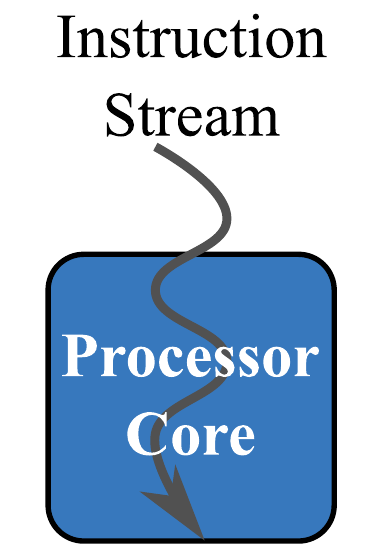

In [6]:
Image("serial_proc.png")

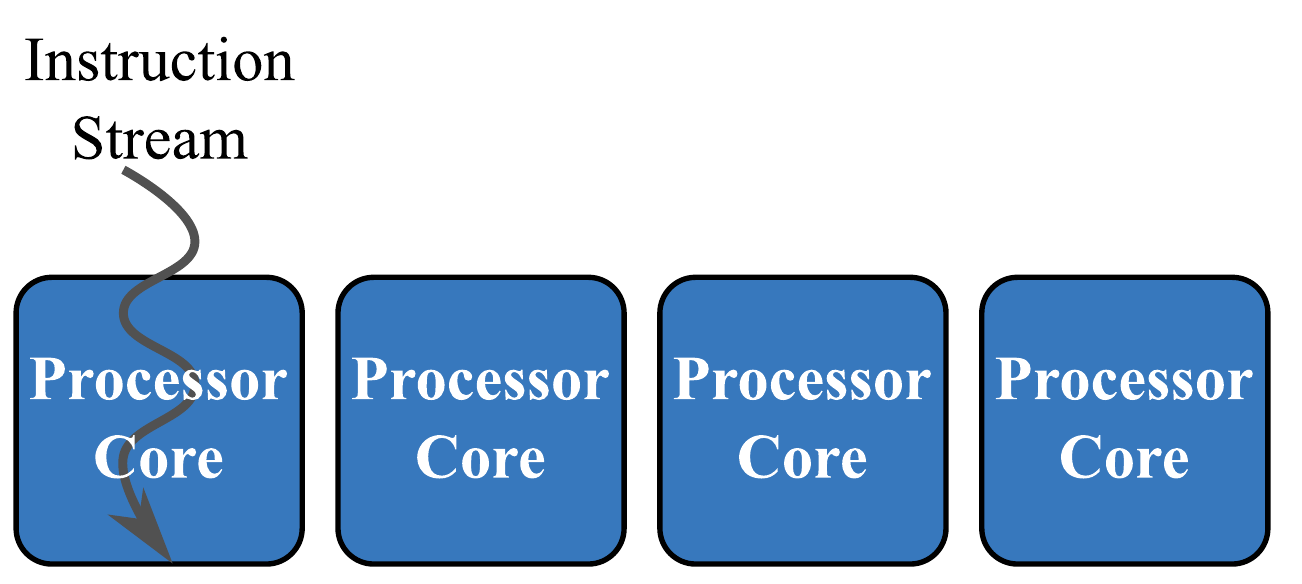

In [7]:
Image("multicore_proc.png")

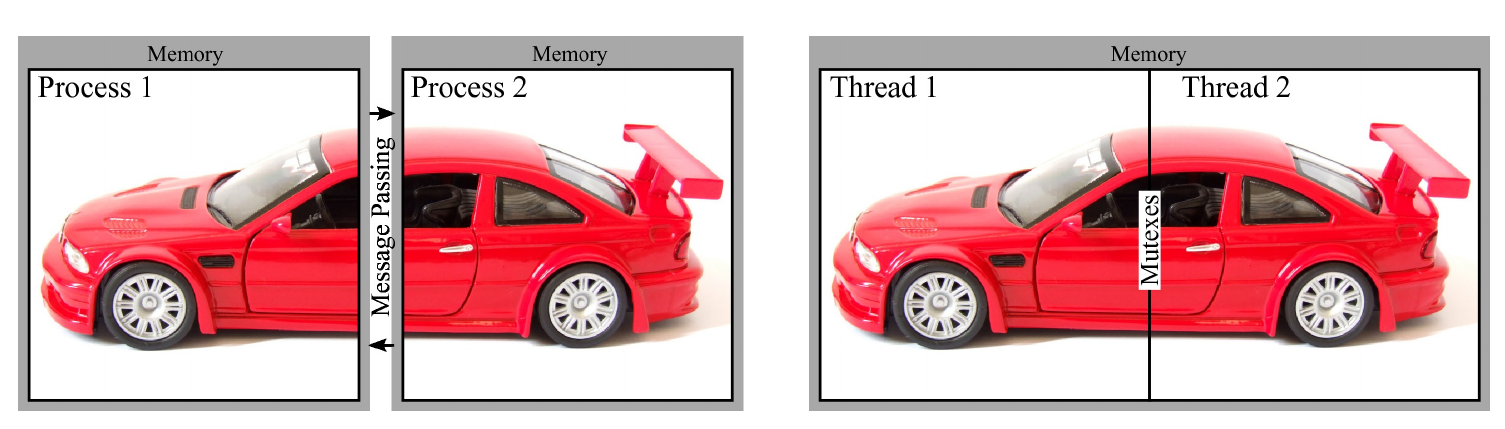

In [8]:
Image("threads_vs_procs.png")

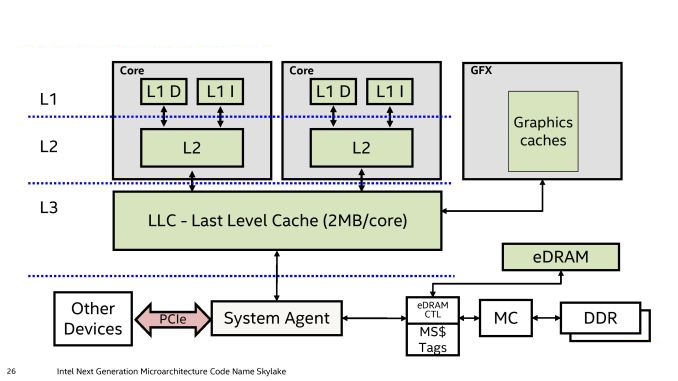

In [9]:
Image("coffe_lake.jpg")

**Shared memory computer** : any computer composed of multiple processing elements that share an address space.

Two Classes:
- Symmetric multiprocessor (SMP): a shared address space with “equal-time” access for each processor, and the OS treats every processor the same way. (Real SMP have not existed for many years, see slides of class#1)

- Non Uniform address space multiprocessor (NUMA;you have one of these): different memory regions have different access costs ... think of memory segmented into “Near” and “Far” memory.

**Process**
- An instance of a program execution.
- The execution context of a running program ... i.e. the resources associated with a program’s execution.

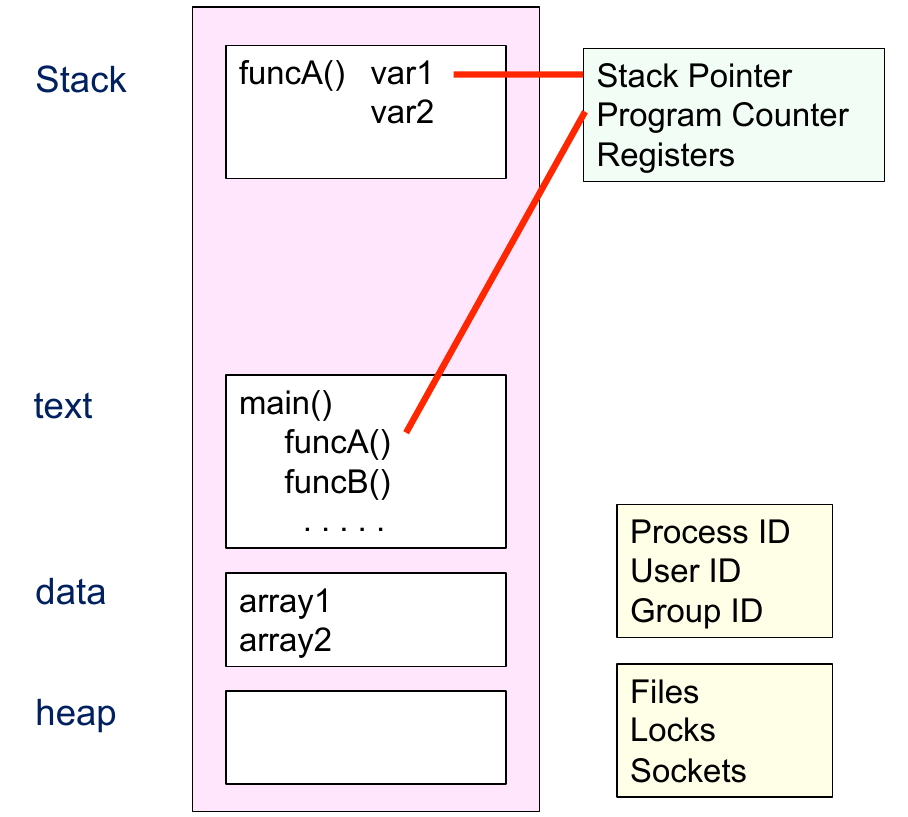

In [10]:
Image("process.png")

**Thread**:

- Threads are "light weight processes”
- Threads share process state among multiple threads ... this greatly reduces the cost of switching context.

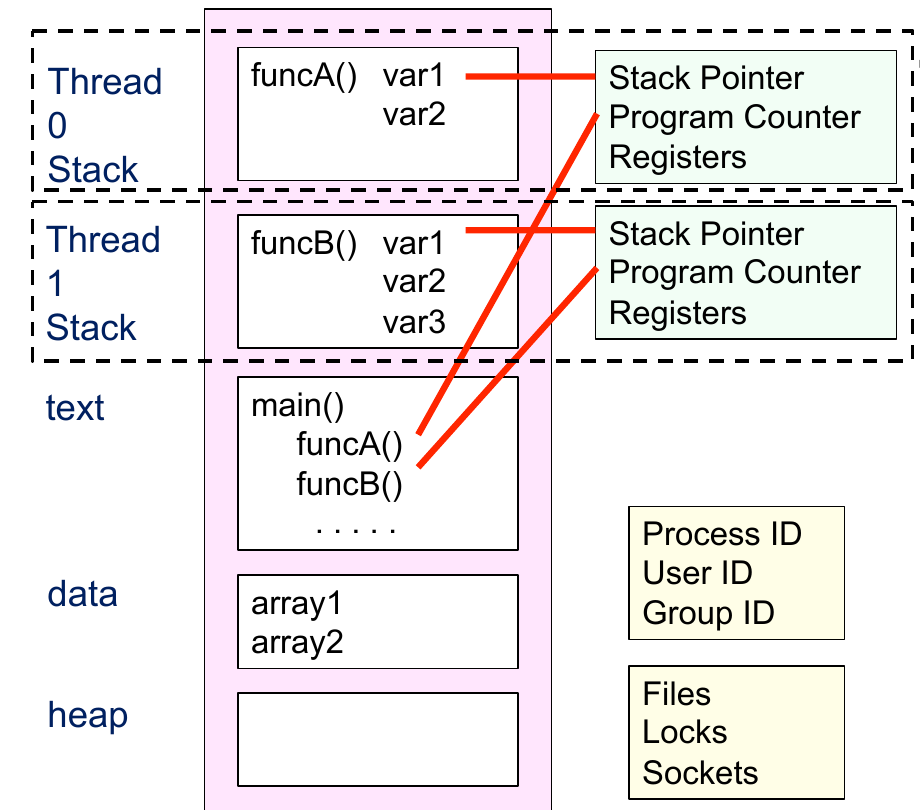

In [11]:
Image("Thread.png")

** A shared memory program**

- One process and lots of threads.
- Threads interact through reads/writes to a shared address space.
- An OS scheduler decides when to run which threads ... interleaved for fairness.
- Synchronization to assure every legal order results in correct results.

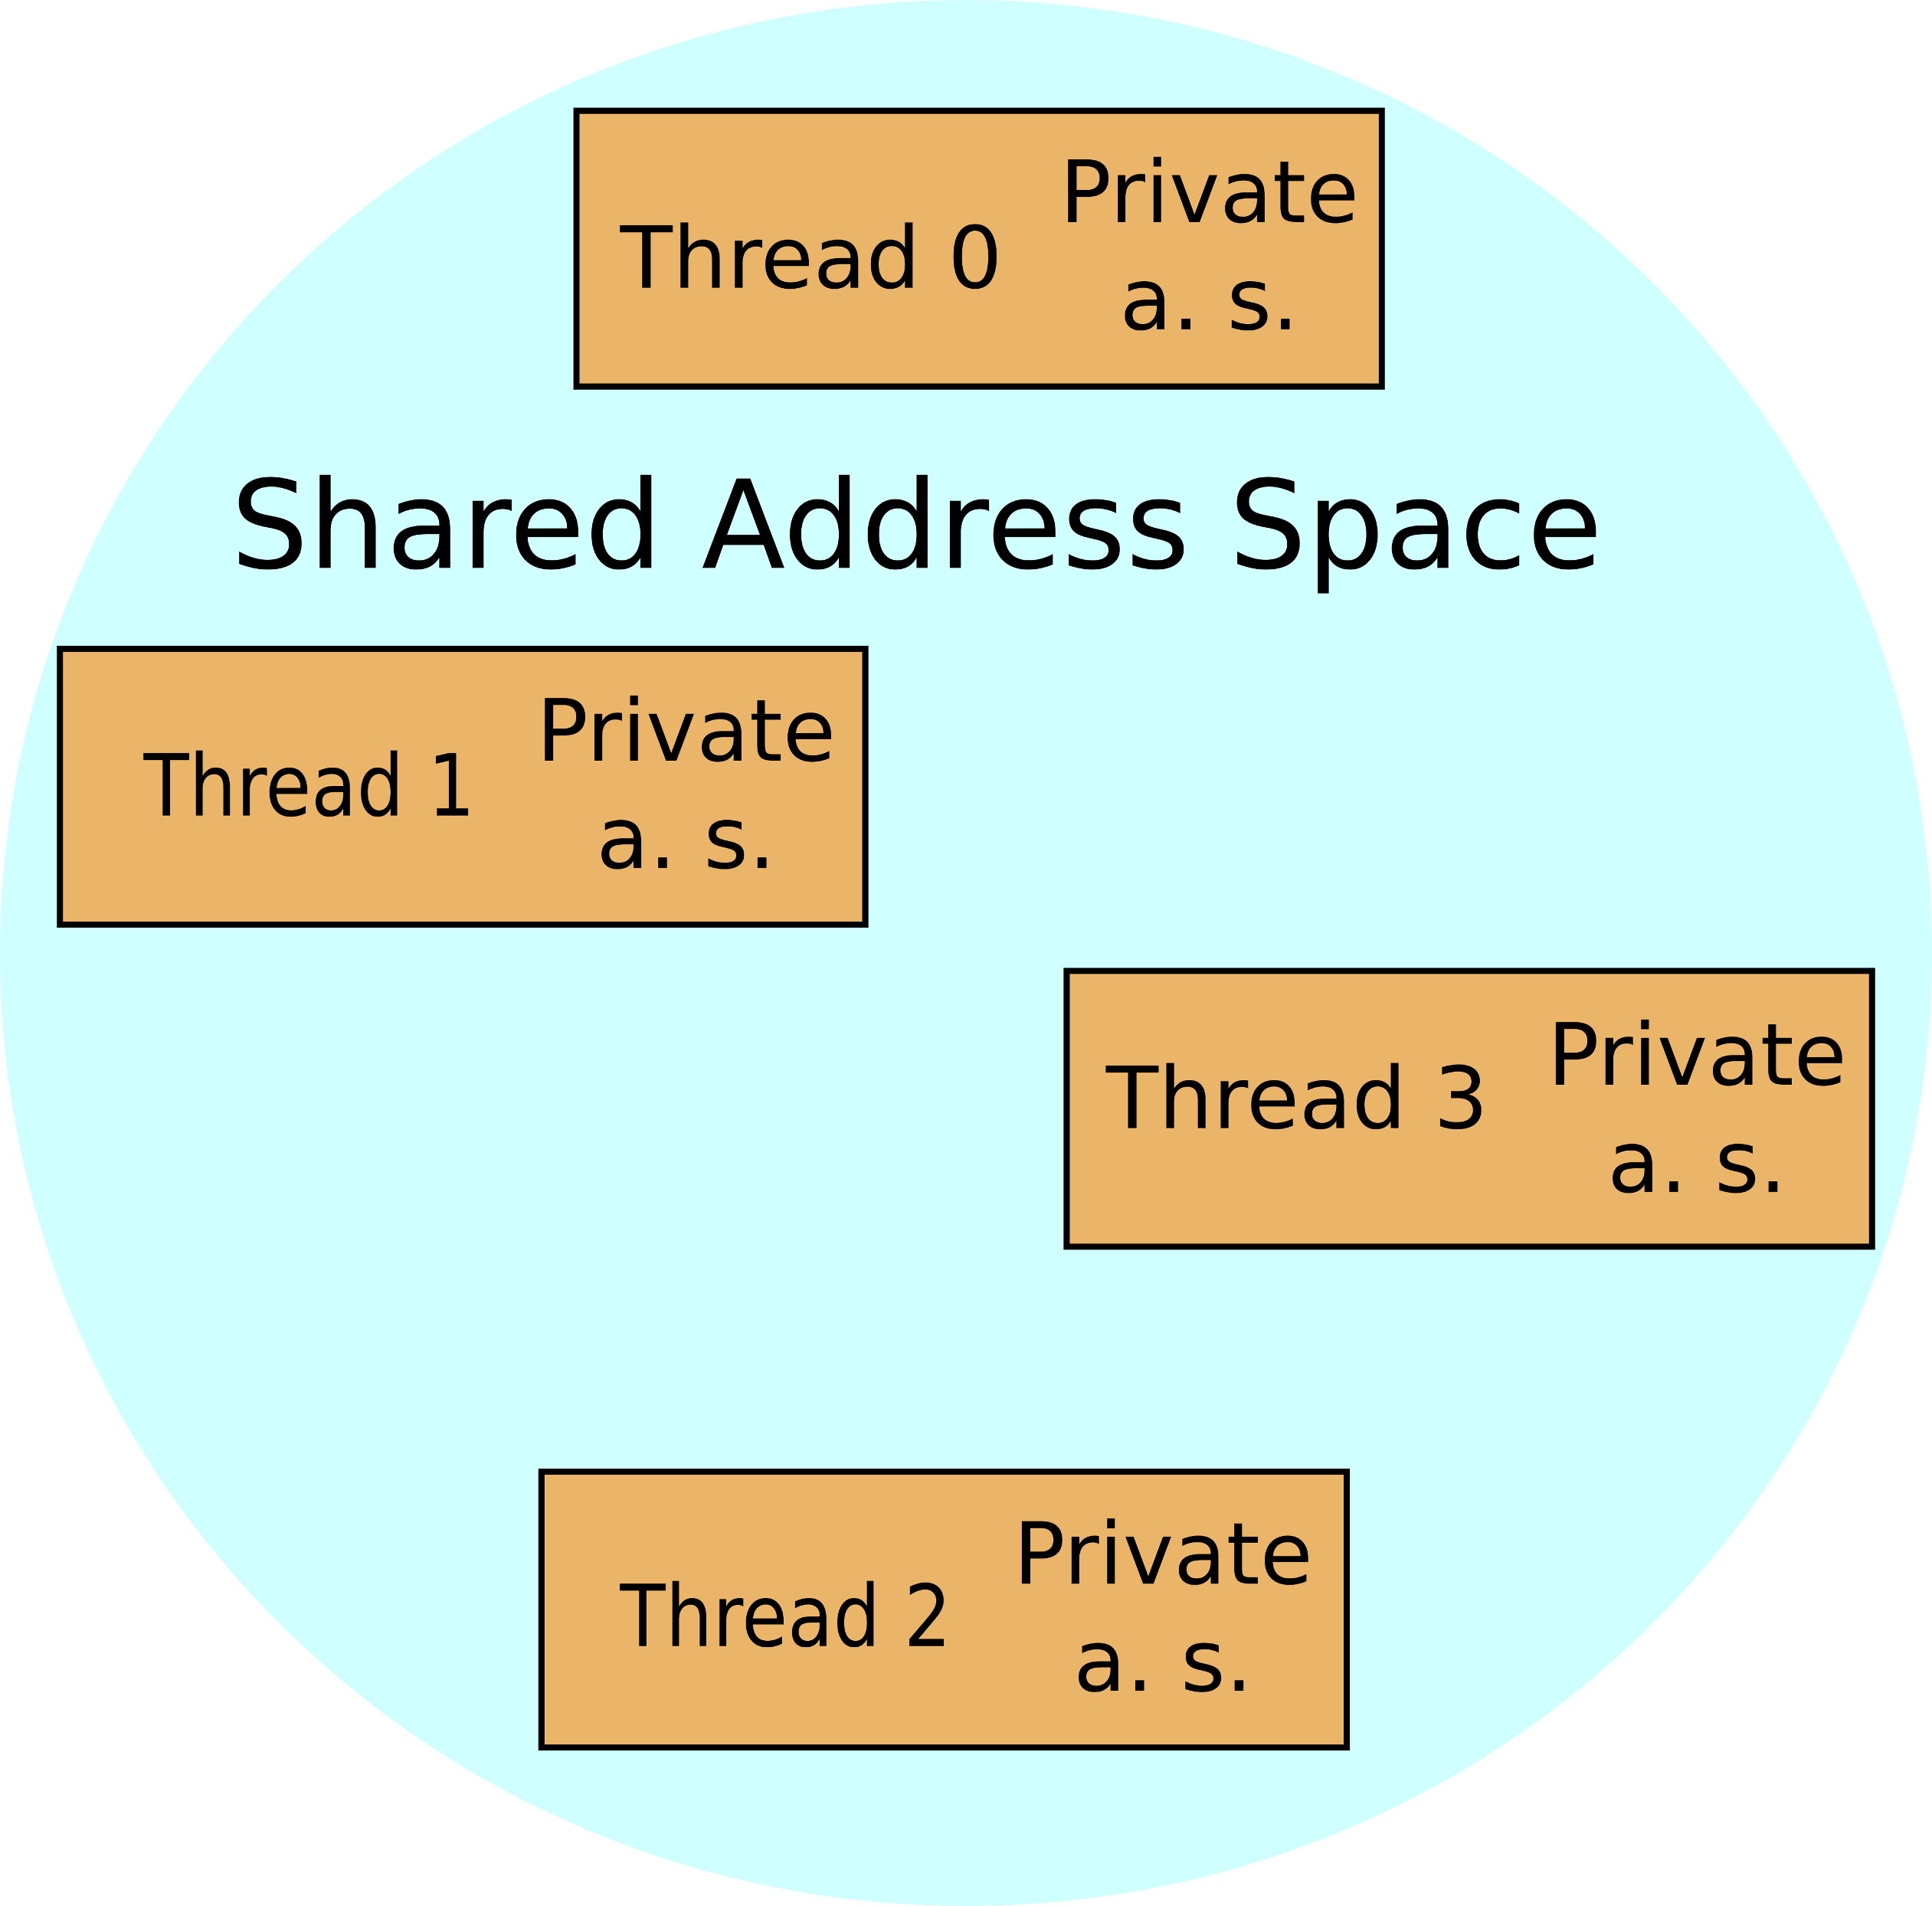

In [12]:
Image("address_space.png")

How do threads interact?

- Threads communicate by sharing variables.
- Unintended sharing of data causes **race conditions**:
    - race condition: when the program’s outcome changes as the threads are scheduled differently.
- To control race conditions:
    - Use synchronization to protect data conflicts.
- Synchronization is expensive so:
    - Change how data is accessed to minimize the need for synchronization.

**Threading Frameworks**  

| Framework     | Functionality | 
|---------------|---------------|
| C++11 Threads | Asynchronous functions; only C++ |
| POSIX Threads | Fork/join; C/C++/Fortran; Linux |
| Cilk Plus     | Async tasks, loops, reducers, load balance; C/C++
| TBB           | Trees of tasks, complex patterns; only C++
| OpenMP        | Tasks, loops, reduction, load balancing, affinity, nesting, C/C++/Fortran (+SIMD, offload)


How many cores we have? On Unix like system the system pseudo filesystem containts a lot of information:

In [13]:
!ls /sys/devices/system/cpu/

cpu0  cpu3  cpu6     cpuidle	 modalias  possible  probe
cpu1  cpu4  cpu7     kernel_max  offline   power     release
cpu2  cpu5  cpufreq  microcode	 online    present   uevent


sysfs is a ram-based filesystem initially based on ramfs. It provides a means to export kernel data structures, their attributes, and the  linkages between them to userspace.

I am not sure what's the most basic way on Windows but you can try a utility such as [CPU-Z](#https://www.cpuid.com/softwares/cpu-z.html).

To sum up:


**Processes**: a process is a set of independent executions that run in a memory space separated from other processes. It has a private virtual address space, environment variables and OS identifiers. A process may split its sequence of executions in one or more threads.

**Threads**: a thread is a sequence of executions that be scheduled in a process. Multiple threads belonging to the same process will share the same environment variables, OS indentifier (PID in GNU/Linux) and virtual address space.

<a id="one"></a>

# 1 - What is OpenMP

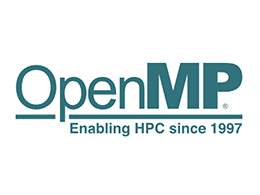

In [14]:
Image("openmp_vignette.jpg")

**OpenMP** i. e. *Open Multi Processing* an Application Program Interface (API) for developing multithreaded applications.

- Vendor independent standard, steered by and independent team (see the [website](#https://www.openmp.org/about/our-team/)
- Supported by vendor and free compilers (Intel, GNU, Portland, CLang, Visual Studio)
- Multiplatform
- Gentle learning curve
- Supports C, C++ and Fortran
- Strongly oriented to numerical computing and HPC

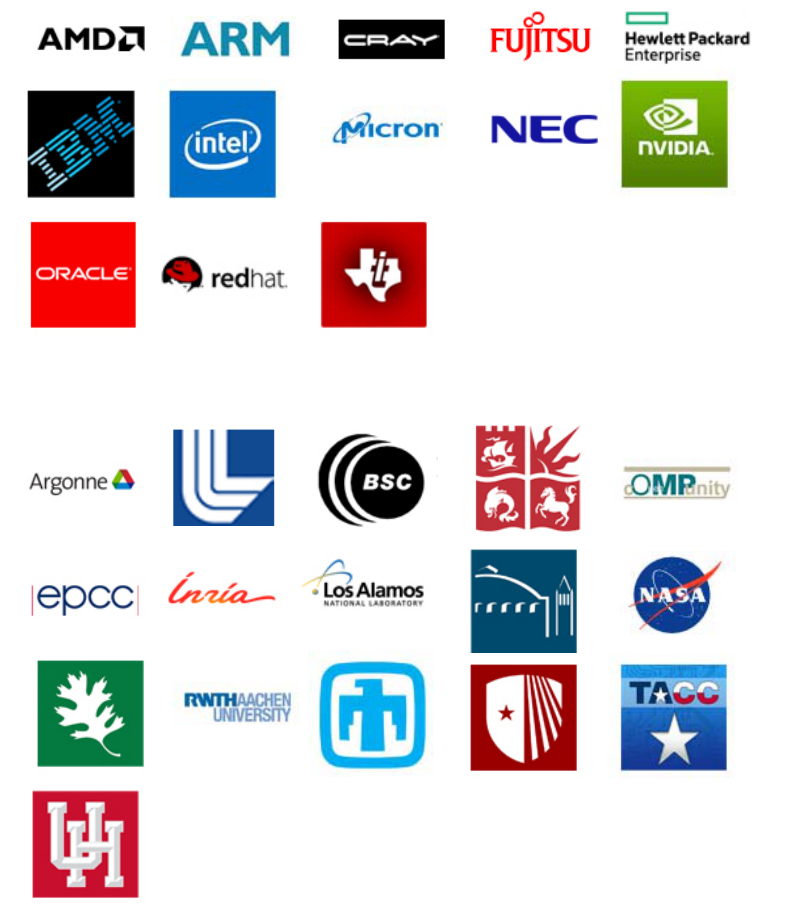

In [15]:
Image("consortium.png")

**OpenMP: a brief history**

- 1996 - Architecture Review Board (ARB) formed by several vendors implementing their own directives for Shared Memory Parallelism (SMP).
- 1997 - 1.0 was released for C/C++ and Fortran with support for parallelizing loops across threads.
- 2000, 2002 – Version 2.0 of Fortran, C/C++ specifications released.
- 2005 – Version 2.5 released, combining both specs into one.
- 2008 – Version 3.0 released, added support for tasking
- 2011 – Version 3.1 release, improved support for tasking
- 2013 – Version 4.0 released, added support for offloading (and more)
- 2015 – Version 4.5 released, improved support for offloading targets (and more)

Look [here](#https://docs.microsoft.com/en-us/previous-versions/visualstudio/visual-studio-2010/tt15eb9t(v=vs.100) for more information about using it in Visual Studio under Windows.

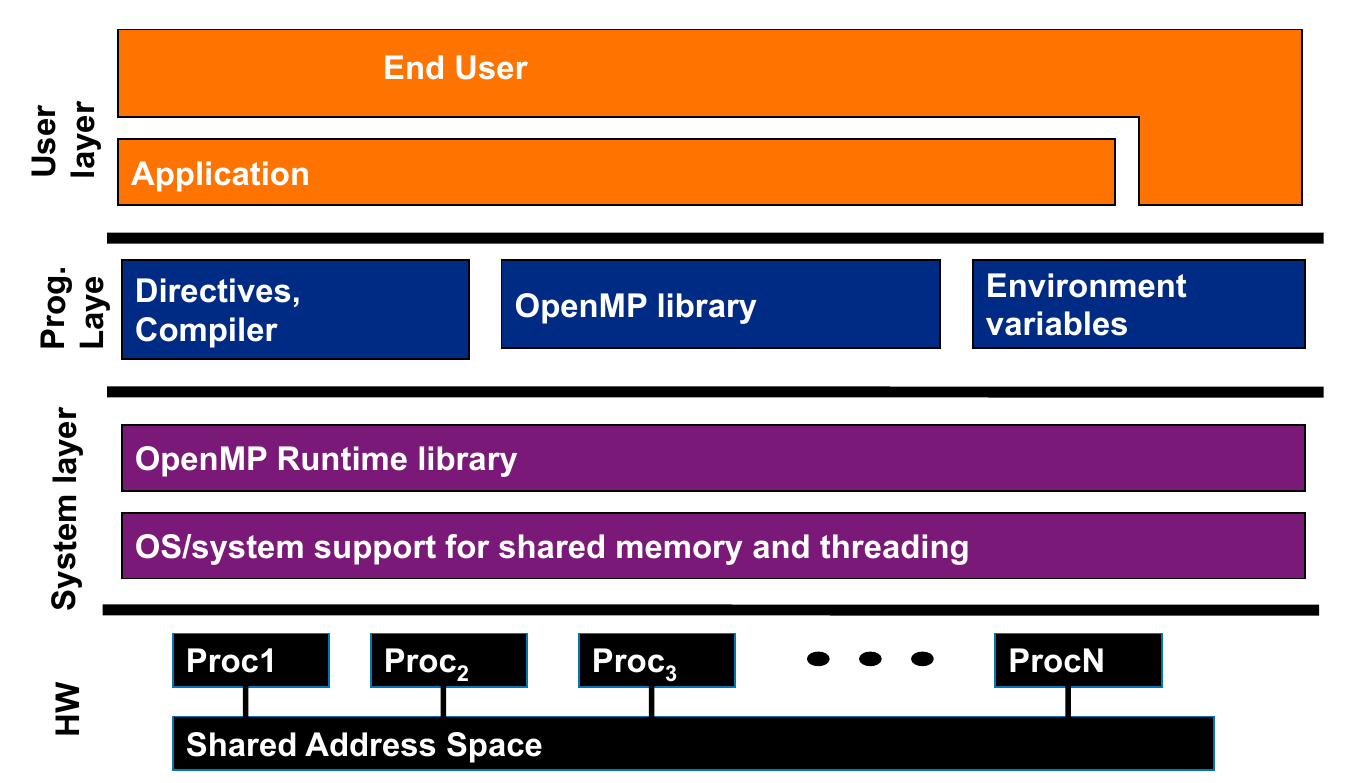

In [16]:
Image("omp_stack.png")

**OpenMP core syntax**

Most of the constructs in OpenMP are compiler directives.
    #pragma omp construct [clause [clause]...]
        
Example
    #pragma omp parallel num_threads(4)
    
Function prototypes and types in the file:
    #include <omp.h>

Most OpenMP constructs apply to a *structured block*:
- Structured block: a block of one or more statements with one point of entry at the top and one point of exit at the bottom.

From Wikipedia:
    
In computer programming, a directive or [pragma](#https://en.wikipedia.org/wiki/Directive_(programming) (from "pragmatic") is a language construct that specifies how a compiler (or other translator) should process its input. Directives are not part of the grammar of a programming language, and may vary from compiler to compiler. They can be processed by a preprocessor to specify compiler behavior, or function as a form of in-band parameterization.

Enough chat. Let's create an Hello World using OpenMP.

In [17]:
%%writefile hello_omp.cc
#include <iostream>
#include <omp.h>

int main()
{
    #pragma omp parallel
    {
        int thread_id = omp_get_thread_num();
        int nt = omp_get_max_threads();
        std::cout << "Hello World! from thread " << thread_id << "out of " << nt << std::endl;
    }
}

Writing hello_omp.cc


Note that the API provides several functions. 
`omp_get_thread_num()` gives you the thread ID (from 0 to the number of threads-1 *even for Fortran!")

In [18]:
%%bash
g++ -Wall -fopenmp hello_omp.cc

To compile with OpenMP:  

    - gcc/g++/gfortran -fopenmp (we already know actually)
    - pgcc/pgCC/pgfortran -mp
    - icc/icpc/ifort -openmp

In [19]:
%%bash
OMP_NUM_THREADS=2 ./a.out

Hello World! from thread Hello World! from thread 01out of out of 22



Note also that the OpenMP settings are controlled by severals environment variables.  
Arguably `OMP_NUM_THREADS` is the most important one.  
It defaults to the number of available cores.  

What about Fortran?

In [20]:
%%writefile hello_omp.f95
program hello

    external omp_get_thread_num, omp_get_wtime
    integer:: omp_get_thread_num
    real(8):: omp_get_wtime
            
    !$OMP parallel
        write(6,*) 'Hello World ! from thread ', omp_get_thread_num(),' at time ',omp_get_wtime()
    !$OMP end parallel
        
end program hello        

Overwriting hello_omp.f95


Please note:
    
- the `!$OMP` (or `C$OMP`) *sentinel* in place of the *pragma* directive
- that function names are the same
- the useful `omp_get_wtime()` we already used in the vectorization class

In [21]:
%%bash
gfortran -Wall -fopenmp hello_omp.f95
./a.out

 Hello World ! from thread            0  at time    2860656.6150397318     
 Hello World ! from thread            4  at time    2860656.6151453569     
 Hello World ! from thread            1  at time    2860656.6151995780     
 Hello World ! from thread            3  at time    2860656.6152756470     
 Hello World ! from thread            7  at time    2860656.6153374342     
 Hello World ! from thread            6  at time    2860656.6160463602     
 Hello World ! from thread            5  at time    2860656.6161675579     
 Hello World ! from thread            2  at time    2860656.6163648381     


<a id="two"></a>

# 2 - The OpenMP programming model

**Fork-Join** Parallelism:

The Master thread spawns a team of threads as needed. Parallelism is added (where meaningful) incrementally until performance goals
are met: i.e. the sequential program evolves into a parallel program.

*Parallel regions* are created with OpenMP whenever you invoke `#pragma omp parallel`. From that point until the end of the region (structured block closed or `!$OMP end parallel`) a *team of threads* is spawned and the code is executed indepently by each thread.  
Before and after only the master thread is active.  
Repetita iuvant: *Each thread executes the same code redundantly*.  
You can also have *nested parallel regions*.

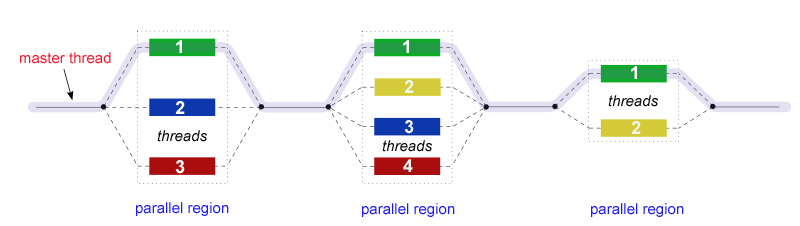

In [22]:
Image("fork_join.jpeg")

In [23]:
%%writefile team.c
#include <stdlib.h>
#include <stdio.h>
#include <omp.h>

void foo(int ID, int *arr)
{
    arr[ID] = ID*10;
}

int main()
{
    int myArray[10];
    omp_set_num_threads(4); //another function to fix the the number of threads to a desired value
    #pragma omp parallel
    {
        int ID = omp_get_thread_num(); // get a numeric ID unique for each thread; ID is private to each thread
        foo(ID,myArray);  //myArray is shared
    }   // implicit barrier; often people denote with //omp parallel
    
    for (int i = 0; i < 4; i++) printf("%d %d\n",i,myArray[i]); //try to use omp_get_num_threads() in the loop
    return 0;
}

Writing team.c


In [24]:
%%bash
gcc -Wall -O2 -fopenmp -std=c99 -o team.exe team.c
./team.exe

0 0
1 10
2 20
3 30


    #pragma	omp	parallel num_threads(4)	//set number of threads in the directive
    {	
        foobar();	
    }	

the code above is *translated* by OpenMP into something like that:

    void thunk()	 
    {	
        foobar();	
    }	

    pthread_t tid[4];	

    for	(int i = 1;	i <	4; i++)	 
        pthread_create(&tid[i],0,thunk,0);	
    thunk();	

    for	(int i = 1;	i <	4; i++) 
        pthread_join(tid[i]);	

All known OpenMP implementations use a thread pool so full cost of threads creation and destruction is not incurred for reach parallel region.  
Only three threads are created because the last parallel section will be invoked from the parent thread.

## Exercise 1: OpenMP mid rectangle integration

again we take as an example numerical integration:

$$ I = \int_0^a f(x)dx \approx \sum_{i=0}^{n-1} f(x_{i+\frac{1}{2}})\Delta x $$
where
$$ \Delta x=\frac{a}{n}, x_{i+\frac{1}{2}} = (i+\frac{1}{2}) \Delta x $$

try to write an OpenMP version **using only pragmas and functions shown above**.

A utility Makefile is provided:

In [1]:
%%writefile Makefile
CC=gcc
CXX=g++
FC=gfortran
CXXFLAGS= -Wall -fopenmp
OFLAGS= -O2
LDFLAGS=-lm -fopenmp
SHELL   = /bin/sh

ifneq ($(mygcc),)
    CXX = /usr/local/gcc-7.3.0/bin/g++
    FC  = /usr/local/gcc-7.3.0/bin/gfortran
    LDFLAGS += -L/usr/local/gcc-7.3.0/lib64
    CPPFLAGS=-I/usr/local/gcc-7.3.0/include    
endif

ifneq ($(opt),)
    CXXFLAGS  += $(OFLAGS)
endif

FFLAGS = $(CXXFLAGS)

serial: integral.o eval_func.o
	$(CXX) -o integral.exe integral.o eval_func.o $(LDFLAGS)

openmp: integral_omp.o eval_func.o
	$(CXX) -o integral.exe integral_omp.o eval_func.o $(LDFLAGS)
    
openmp_pad: integral_omp_pad.o eval_func.o
	$(CXX) -o integral.exe integral_omp_pad.o eval_func.o $(LDFLAGS)    

f95_serial: integral.fo eval_func.fo
	$(FC) -o integral.exe integral.fo eval_func.fo $(LDFLAGS)
	
f95_omp: integral_omp.fo eval_func.fo
	$(FC) -o integral.exe integral_omp.fo eval_func.fo $(LDFLAGS)
	
integral_omp.fo: eval_func.fo

integral.fo: eval_func.fo 

%.o : %.cc
	$(CXX) -c $(CXXFLAGS) $(CPPFLAGS) $< -o $@
	
%.fo: %.f95
	$(FC) -c $(FFLAGS) $(CPPFLAGS) $< -o $@

.PHONY: clean   
clean:
	rm -f integral*o eval_func*o integral.exe myodule.mod


Writing Makefile


As well as serial C++ and Fortran versions

In [26]:
%%writefile integral.cc
#include "integral.h"

int main(int argc, char **argv)
{
    
    int num_steps = argv[1] != NULL ? atoi(argv[1]) : 1E8;
    double start = 0.;
    double end   = 1.;
    
    double I  = 0.;
    double dx = (end-start) / ((double ) num_steps);
    
    double t0 = omp_get_wtime();
    for(int i=0; i< num_steps; i++)
    {
        double mid_x = start + dx * ((double ) i + 0.5);
        double mid_y = eval_func(mid_x);
        I += mid_y;
    }
    I *= dx;
    double t1 = omp_get_wtime();
    
    std::cout  << "Loop completed in "<< 1000.*(t1-t0) << " ms" << std::endl;
    std::cout  << "Integral value = " << I << std::endl;
}

Writing integral.cc


In [27]:
%%writefile integral.f95
program integral
    use mymodule
    implicit none

    integer :: num_steps, i
    real(8) :: first, last, dx
    real(8) :: myInt, mid_x, mid_y, t0, t1
    
    external omp_get_wtime
    real(8)  omp_get_wtime

    first = 0.d0
    last  = 1.d0
    myInt = 0.d0
    num_steps = 1e8
    dx = (last-first)/num_steps

    t0 = omp_get_wtime();
    do i = 1,num_steps
        
        mid_x = first + i * dx
        mid_y = eval_func(mid_x)
        myInt = myInt + mid_y
        
    end do
    myInt = myInt*dx
    t1 = omp_get_wtime();
    
    write(6,*) 'Loop completed in ',1000.d0*(t1-t0),' ms'
    write(6,*) 'Integral value ', myInt
    
end program integral

Overwriting integral.f95


In [28]:
%%writefile integral.h
#include <iostream>
#include <cstdlib>
#include <cstdio>
#include <omp.h>
#include <unistd.h>

double eval_func(double x);

Writing integral.h


In [29]:
%%writefile eval_func.cc
#include "integral.h"

double eval_func(double x)
{
    return 4.0/(1. + x*x) ;
}

Writing eval_func.cc


In [30]:
%%writefile eval_func.f95
module mymodule
    
    contains

    real(8) function eval_func(x)
        real(8), intent(in) :: x

        eval_func = 4.d0/(1.d0 + x * x)
    end function eval_func

end module mymodule

Overwriting eval_func.f95


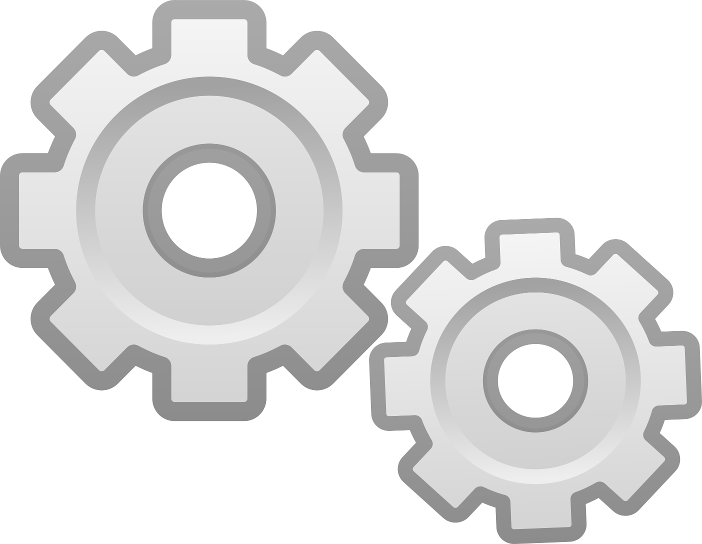

In [31]:
Image("gears.png")

**1** C++ solution.

In [32]:
%%writefile integral_omp.cc
#include "integral.h"

 //check cmd line arguments
int main(int argc, char **argv)
{
    int num_steps = 1E8;
    double start  = 0.;
    double end    = 1.;
    
    double I  = 0.;
    double dx = (end-start) / ((double ) num_steps);
    
    double t0 = omp_get_wtime();   
    int num_threads;
    
    #pragma omp parallel
    {
        num_threads = omp_get_num_threads();
    }
    double sum[num_threads] = {0};
    
    #pragma omp parallel
    {
        int thread_id = omp_get_thread_num();
        
        for(int i = thread_id; i< num_steps; i = i + num_threads)
        {
            double mid_x = start + dx * ((double ) i + 0.5);
            double mid_y = eval_func(mid_x);
            sum[thread_id] += mid_y;
        }            
    }
    
    for(int i = 0; i< num_threads; i++)
        I += sum[i];
    I *= dx;
    
    double t1 = omp_get_wtime();
    
    std::cout  << "Loop completed in "<< 1000.*(t1-t0) << " ms using " \
    << num_threads << " threads" << std::endl;
    std::cout  << "Integral value = " << I << std::endl;
}

Writing integral_omp.cc


We *promote* `sum` to a vector to store partial sums.

In [33]:
%%bash
export LD_LIBRARY_PATH=/usr/local/gcc-7.3.0/lib64/:$LD_LIBRARY_PATH
make clean && make openmp mygcc=1
OMP_NUM_THREADS=2 ./integral.exe

rm -f integral*o eval_func*o integral.exe myodule.mod
/usr/local/gcc-7.3.0/bin/g++ -c -Wall -fopenmp -I/usr/local/gcc-7.3.0/include     integral_omp.cc -o integral_omp.o
/usr/local/gcc-7.3.0/bin/g++ -c -Wall -fopenmp -I/usr/local/gcc-7.3.0/include     eval_func.cc -o eval_func.o
/usr/local/gcc-7.3.0/bin/g++ -o integral.exe integral_omp.o eval_func.o -lm -fopenmp -L/usr/local/gcc-7.3.0/lib64
Loop completed in 2895.62 ms using 2 threads
Integral value = 3.14159


In [34]:
%%capture cpbench
%%bash
export LD_LIBRARY_PATH=/usr/local/gcc-7.3.0/lib64/:$LD_LIBRARY_PATH
make clean && make openmp opt=1 mygcc=1    
OMP_NUM_THREADS=1 ./integral.exe
OMP_NUM_THREADS=2 ./integral.exe
OMP_NUM_THREADS=3 ./integral.exe
OMP_NUM_THREADS=4 ./integral.exe

In [35]:
pat = re.compile(r'(Loop\scompleted\sin\s)(.+)\sms')
cpres = pat.findall(cpbench.stdout) 
cpres = np.array(list(map(lambda x:float(x[-1]),cpres)))

**2** F95 solution

In [36]:
%%writefile integral_omp.f95
program integral
    use mymodule
    implicit none

    integer :: num_steps, num_threads, i
    real(8) :: first, last, dx, t0, t1, PI
    real(8), dimension(:), allocatable :: myInt
    
    external omp_get_wtime, omp_get_num_threads
    real(8) :: omp_get_wtime
    integer :: omp_get_num_threads

    first = 0.d0
    last  = 1.d0
    PI    = 0.d0
    num_steps = 1e8
    dx = (last-first)/num_steps
    
    !$OMP parallel 
        num_threads = omp_get_num_threads()
    !$OMP end parallel
    allocate (myInt(num_threads))
    
    t0 = omp_get_wtime();
    !$OMP parallel 
        call midrect(myInt, first ,dx, num_steps, num_threads)           
    !$OMP end parallel
    
    do 10 i = 1, num_threads
10      PI = PI + myInt(i)    
    PI = PI * dx
    t1 = omp_get_wtime();
    
    write(6,*) 'Loop completed in ',1000.d0*(t1-t0),' ms'
    write(6,*) 'Integral value ', PI
    
    contains
    
    subroutine midrect(myInt, first, dx, num_steps, num_threads)
    
        real(8), intent(in) :: first, dx
        real(8), dimension (*), intent(inout) :: myInt
        integer, intent(in) :: num_steps, num_threads

        external omp_get_thread_num
        real(8) :: mid_x, mid_y
        integer :: thread_id, i, omp_get_thread_num
        
        thread_id = omp_get_thread_num() 
        
        do 10 i = thread_id, num_steps-1, num_threads
            mid_x = first + dble(i) * dx
            mid_y = eval_func(mid_x)
            myInt(thread_id+1) = myInt(thread_id+1) + mid_y
10      continue        

    end subroutine    
    
end program integral

Overwriting integral_omp.f95


In [37]:
%%bash
export LD_LIBRARY_PATH=/usr/local/gcc-7.3.0/lib64/:$LD_LIBRARY_PATH
make clean && make f95_omp mygcc=1
OMP_NUM_THREADS=1 ./integral.exe

rm -f integral*o eval_func*o integral.exe myodule.mod
/usr/local/gcc-7.3.0/bin/gfortran -c -Wall -fopenmp -I/usr/local/gcc-7.3.0/include     eval_func.f95 -o eval_func.fo
/usr/local/gcc-7.3.0/bin/gfortran -c -Wall -fopenmp -I/usr/local/gcc-7.3.0/include     integral_omp.f95 -o integral_omp.fo
/usr/local/gcc-7.3.0/bin/gfortran -o integral.exe integral_omp.fo eval_func.fo -lm -fopenmp -L/usr/local/gcc-7.3.0/lib64
 Loop completed in    2120.4804400913417       ms
 Integral value    3.1415926635902252     


In [38]:
%%capture fbench
%%bash
export LD_LIBRARY_PATH=/usr/local/gcc-7.3.0/lib64/:$LD_LIBRARY_PATH
make clean && make f95_omp mygcc=1 opt=1
OMP_NUM_THREADS=1 ./integral.exe
OMP_NUM_THREADS=2 ./integral.exe
OMP_NUM_THREADS=3 ./integral.exe
OMP_NUM_THREADS=4 ./integral.exe

In [39]:
pat = re.compile(r'(Loop\scompleted\sin\s+)(.+)\s+ms')
f95res = pat.findall(fbench.stdout) 
f95res = np.array(list(map(lambda x:float(x[-1]),f95res)))

Algorithm strategy:

The **SPMD** (Single Program Multiple Data) design pattern
- Run the same program on P processing elements where P can be arbitrarily large.
- Use the rank ... an ID ranging from 0 to (P-1) ... to select between a set of tasks and to manage any shared data structures.

This pattern is very general and probably the most widely used in parallel programming. 

This sound very nice, but look at the actual scaling:

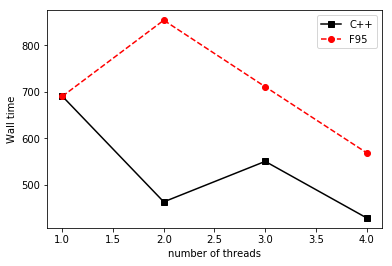

In [40]:
plt.plot(np.arange(1,5),cpres,marker='s',color='k',ls='-',label='C++')
plt.plot(np.arange(1,5),f95res,marker='o',color='r',ls='--',label='F95')
plt.ylabel('Wall time')
plt.xlabel('number of threads')
plt.legend()

any idea?

If independent data elements happen to sit on the same cache line, each update will cause the cache lines to “slosh back and forth” between threads.  
This is called **false sharing**.

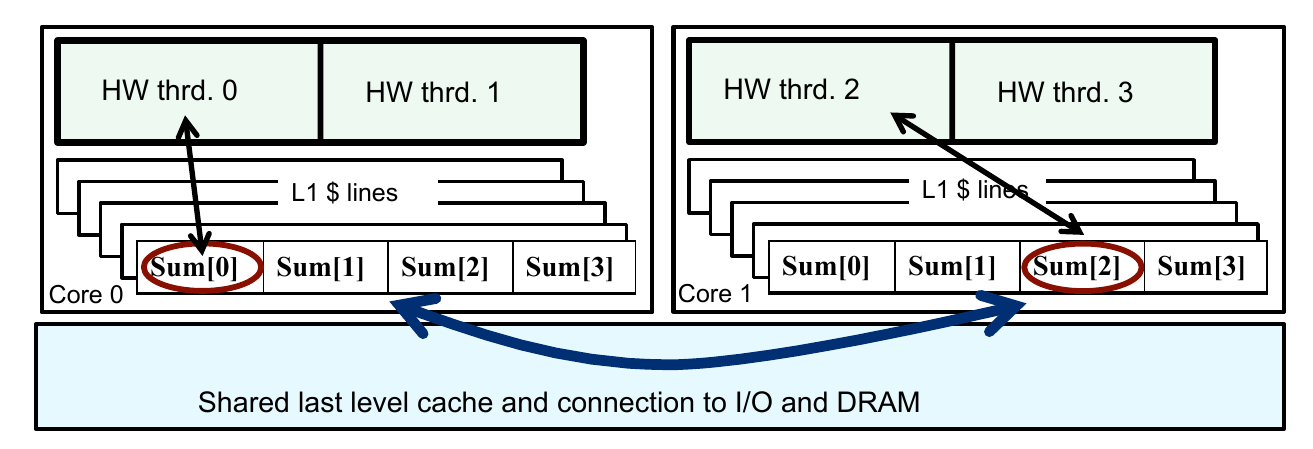

In [41]:
Image("false_sharing.png")

If you promote scalars to an array to support creation of an SPMD program, the array elements are contiguous in memory and hence share cache lines. Hence, you have poor scalability.
Solution: Pad arrays so elements you use are on distinct cache lines.

In [42]:
%%writefile integral_omp_pad.cc
#include "integral.h"

int main(int argc, char **argv)
{
    
    int num_steps = 1E8;
    double start  = 0.;
    double end    = 1.;
    
    double I  = 0.;
    double dx = (end-start) / ((double ) num_steps);
    int linesz = getpagesize();
    std::cout <<" Cache Line Size " << linesz << " byte" << std::endl;
    double t0 = omp_get_wtime();   
    int num_threads;
    
    #pragma omp parallel
    {
        num_threads = omp_get_num_threads();
    }
    double sum[num_threads][linesz/sizeof(double)] = {0};
    
    #pragma omp parallel
    {
        int thread_id = omp_get_thread_num();             
        
        for(int i=thread_id; i< num_steps; i = i + num_threads)
        {
            double mid_x = start + dx * ((double ) i + 0.5);
            double mid_y = eval_func(mid_x);
            sum[thread_id][0] += mid_y;
        }       
    }
    
    for(int i = 0; i < num_threads; i++)
        I += sum[i][0];
    I *= dx;
    double t1 = omp_get_wtime();
    
    std::cout  << "Loop completed in "<< 1000.*(t1-t0) << " ms using " \
    << num_threads << " threads" << std::endl;
    std::cout  << "Integral value = " << I << std::endl;
}

Writing integral_omp_pad.cc


`getpagesize` gives the cache line size as looking in sysfs would

In [43]:
%%bash
export LD_LIBRARY_PATH=/usr/local/gcc-7.3.0/lib64/:$LD_LIBRARY_PATH
make clean && make openmp_pad mygcc=1
OMP_NUM_THREADS=2 ./integral.exe

rm -f integral*o eval_func*o integral.exe myodule.mod
/usr/local/gcc-7.3.0/bin/g++ -c -Wall -fopenmp -I/usr/local/gcc-7.3.0/include     integral_omp_pad.cc -o integral_omp_pad.o
/usr/local/gcc-7.3.0/bin/g++ -c -Wall -fopenmp -I/usr/local/gcc-7.3.0/include     eval_func.cc -o eval_func.o
/usr/local/gcc-7.3.0/bin/g++ -o integral.exe integral_omp_pad.o eval_func.o -lm -fopenmp -L/usr/local/gcc-7.3.0/lib64    
 Cache Line Size 4096 byte
Loop completed in 1208.81 ms using 2 threads
Integral value = 3.14159


In [44]:
%%capture cpbench_2
%%bash
export LD_LIBRARY_PATH=/usr/local/gcc-7.3.0/lib64/:$LD_LIBRARY_PATH
make clean && make openmp_pad opt=1 mygcc=1    
OMP_NUM_THREADS=1 ./integral.exe
OMP_NUM_THREADS=2 ./integral.exe
OMP_NUM_THREADS=3 ./integral.exe
OMP_NUM_THREADS=4 ./integral.exe

In [45]:
pat = re.compile(r'(Loop\scompleted\sin\s)(.+)\sms')
cpres_2 = pat.findall(cpbench_2.stdout) 
cpres_2 = np.array(list(map(lambda x:float(x[-1]),cpres_2)))

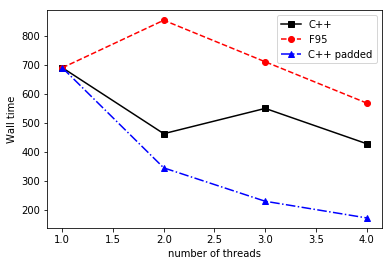

In [46]:
plt.plot(np.arange(1,5),cpres,marker='s',color='k',ls='-',label='C++')
plt.plot(np.arange(1,5),f95res,marker='o',color='r',ls='--',label='F95')
plt.plot(np.arange(1,5),cpres_2,marker='^',color='b',ls='-.',label='C++ padded')
plt.ylabel('Wall time')
plt.xlabel('number of threads')
plt.legend()

In [47]:
cpres_2[0]/cpres_2[-1]

3.9902912621359228

Nice!  

However, padding arrays requires knowledge of the cache architecture and may interfere with portability.  
There has got to be a better way to deal with false sharing.

<a id="three"></a>

# 3- Synchronization

Recall how do threads interact:

- OpenMP is a multi-threading, shared address model: threads communicate by *sharing variables*.
- Unintended sharing of data causes **race conditions** in which the program's results depend on thread scheduling.
- To control race conditions: use **synchronization** to protect data conflicts.
- Synchronization is expensive so: change how data is accessed to minimize the need for synchronization.

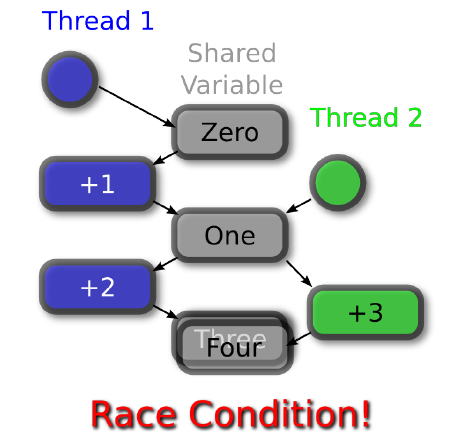

In [48]:
Image("race.png")

    #pragma omp parallel 
    {
        for (int i = 0; i < n; i++)
             total = total + i; // Race condition
    }

**Synchronization**: bringing one or more threads to a well defined and known point in their execution:

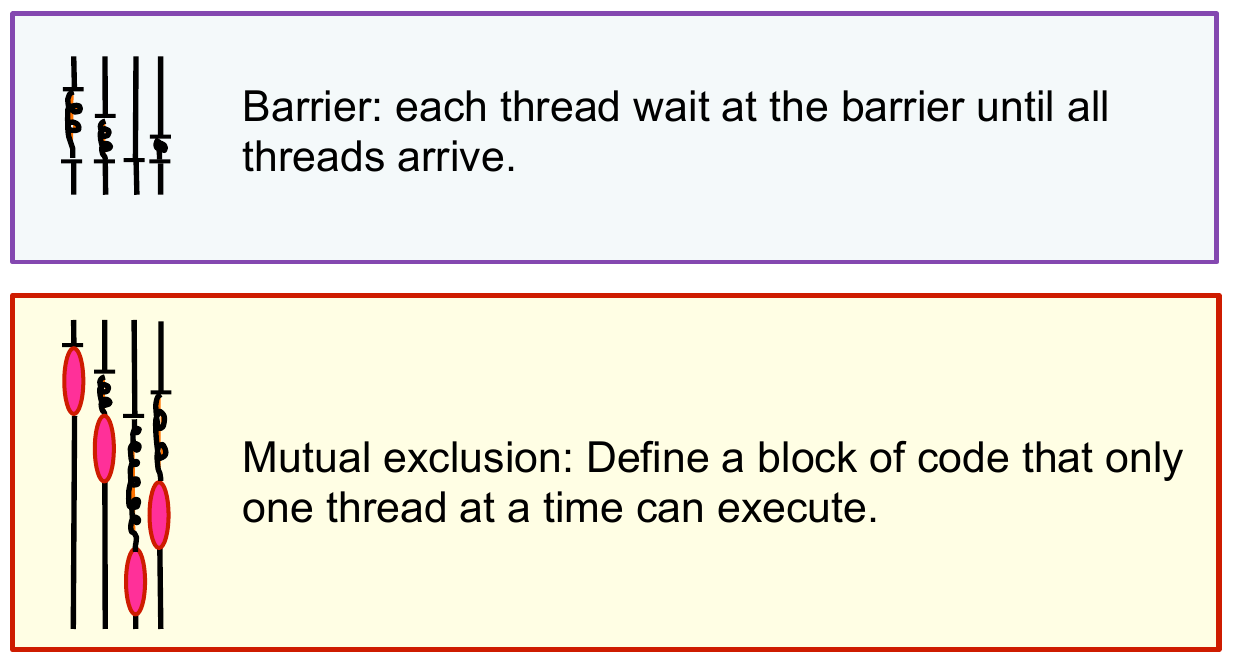

In [49]:
Image("barrier.png")

- High level synchronization:  
    - Critical  
    - Atomic  
    - Barrier  
    - Ordered  
    
- Low level synchronization:
    - Flush
    - Locks

    #pragma omp parallel
    {
        int id=omp_get_thread_num();
        A[id] = big_calc1(id);
    #pragma omp barrier // threads sit here until the last one has completed his job
    }
    B[id] = big_calc2(id, A);

    float res;
    #pragma omp parallel
    {
        float B; int i, id, nthrds;
        id = omp_get_thread_num();
        nthrds = omp_get_num_threads();
        for(i=id;i<niters;i+=nthrds)
        {
            B = big_job(i);
            #pragma omp critical // threads access the critical section one at time: **Mutual Exclusion**
            res += consume (B);
        }
    }

    float res;
    #pragma omp parallel
    {
        float B; int i, id, nthrds;
        id = omp_get_thread_num();
        nthrds = omp_get_num_threads();
        for(i=id;i<niters;i+=nthrds)
        {
            B = big_job(i);
            #pragma omp atomic // threads access the atomic section one at time: **Mutual Exclusion**
            res += B;
        }
    }

**Critical** and **Atomic** are called **Mutexes** (for *Mutual Exclusion*): they protect from data races by serializing code.

**Atomic** provides mutual exclusion but only applies to the update of a memory location and only supports "simple" operators such as `res++, res--, --res, ++res`.

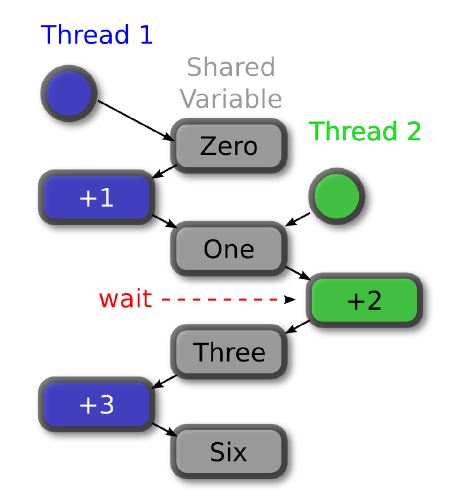

In [50]:
Image("mutex.png")

## Exercise 2: integration with synchronization

Write another version of `integral_omp.cc` (or `integral_omp.f95`) using synchronization pragmas and modify the Makefile accordingly.

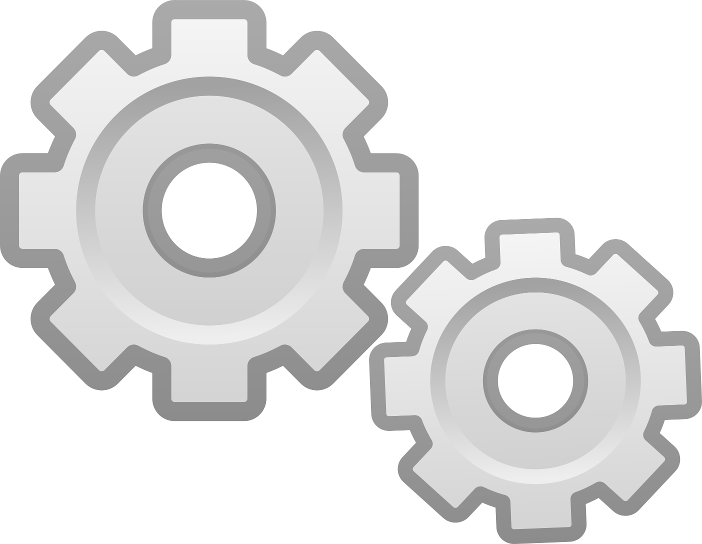

In [51]:
Image("gears.png")

#### Makefile

In [52]:
%%writefile Makefile
CXXFLAGS= -Wall -fopenmp
OFLAGS= -O2
LDFLAGS=-lm -fopenmp
SHELL   = /bin/sh

ifneq ($(mygcc),)
    CXX = /usr/local/gcc-7.3.0/bin/g++
    FC  = /usr/local/gcc-7.3.0/bin/gfortran
    LDFLAGS += -L/usr/local/gcc-7.3.0/lib64
    CPPFLAGS=-I/usr/local/gcc-7.3.0/include    
endif

ifneq ($(opt),)
    CXXFLAGS  += $(OFLAGS)
endif

FFLAGS = $(CXXFLAGS)

serial: integral.o eval_func.o
	$(CXX) -o integral.exe integral.o eval_func.o $(LDFLAGS)

openmp: integral_omp.o eval_func.o
	$(CXX) -o integral.exe integral_omp.o eval_func.o $(LDFLAGS)

openmp_pad: integral_omp_pad.o eval_func.o
	$(CXX) -o integral.exe integral_omp_pad.o eval_func.o $(LDFLAGS)
	
openmp_for: integral_omp_for.o eval_func.o
	$(CXX) -o integral.exe integral_omp_for.o eval_func.o $(LDFLAGS)
	
openmp_red: integral_omp_red.o eval_func.o
	$(CXX) -o integral.exe integral_omp_red.o eval_func.o $(LDFLAGS)
	
openmp_task: integral_omp_task.o eval_func.o
	$(CXX) -o integral.exe integral_omp_task.o eval_func.o $(LDFLAGS)	
	
openmp_task_dac: integral_omp_task_dac.o eval_func.o
	$(CXX) -o integral.exe integral_omp_task_dac.o eval_func.o $(LDFLAGS)	    
    
f95_serial: integral.fo eval_func.fo
	$(FC) -o integral.exe integral.fo eval_func.fo $(LDFLAGS)
	
f95_omp: integral_omp.fo eval_func.fo
	$(FC) -o integral.exe integral_omp.fo eval_func.fo $(LDFLAGS)
	
f95_omp_for: integral_omp_for.fo eval_func.fo
	$(FC) -o integral.exe integral_omp_for.fo eval_func.fo $(LDFLAGS)
	
integral_omp.fo: eval_func.fo

integral_omp_for.fo: eval_func.fo

integral.fo: eval_func.fo 

%.o : %.cc
	$(CXX) -c $(CXXFLAGS) $(CPPFLAGS) $< -o $@
	
%.fo: %.f95
	$(FC) -c $(FFLAGS) $(CPPFLAGS) $< -o $@

.PHONY: clean   
clean:
	rm -f integral*o eval_func*o integral.exe myodule.mod

Overwriting Makefile


#### C++

In [53]:
%%writefile integral_omp_for.cc
#include "integral.h"

int main(int argc, char **argv)
{
    
    int num_steps = 1E8;
    double start  = 0.;
    double end    = 1.;
    
    double I  = 0.;
    double dx = (end-start) / ((double ) num_steps);
    double t0 = omp_get_wtime(); 
    int NN;
    
    #pragma omp parallel
    {
        int thread_id = omp_get_thread_num(); 
        int num_threads = omp_get_num_threads();
        NN = num_threads;
        double mid_y = 0.;
        
        for(int i=thread_id; i< num_steps; i = i + num_threads)
        {
            double mid_x = start + dx * ((double ) i + 0.5);
            mid_y += eval_func(mid_x);
            
        }
            #pragma omp atomic
            I += mid_y;
    }
    
    I = I * dx;
    double t1 = omp_get_wtime();
    
    std::cout  << "Loop completed in "<< 1000.*(t1-t0) << " ms using " \
    << NN << " threads" << std::endl;
    std::cout  << "Integral value = " << I << std::endl;
}

Writing integral_omp_for.cc


In [54]:
%%bash
export LD_LIBRARY_PATH=/usr/local/gcc-7.3.0/lib64/:$LD_LIBRARY_PATH
make clean && make openmp_for mygcc=1
OMP_NUM_THREADS=2 ./integral.exe

rm -f integral*o eval_func*o integral.exe myodule.mod
/usr/local/gcc-7.3.0/bin/g++ -c -Wall -fopenmp -I/usr/local/gcc-7.3.0/include     integral_omp_for.cc -o integral_omp_for.o
/usr/local/gcc-7.3.0/bin/g++ -c -Wall -fopenmp -I/usr/local/gcc-7.3.0/include     eval_func.cc -o eval_func.o
/usr/local/gcc-7.3.0/bin/g++ -o integral.exe integral_omp_for.o eval_func.o -lm -fopenmp -L/usr/local/gcc-7.3.0/lib64
Loop completed in 1051.78 ms using 2 threads
Integral value = 3.14159


In [55]:
%%capture cpbench_3
%%bash
export LD_LIBRARY_PATH=/usr/local/gcc-7.3.0/lib64/:$LD_LIBRARY_PATH
make clean && make openmp_for opt=1 mygcc=1    
OMP_NUM_THREADS=1 ./integral.exe
OMP_NUM_THREADS=2 ./integral.exe
OMP_NUM_THREADS=3 ./integral.exe
OMP_NUM_THREADS=4 ./integral.exe

In [56]:
pat = re.compile(r'(Loop\scompleted\sin\s)(.+)\sms')
cpres_3 = pat.findall(cpbench_3.stdout) 
cpres_3 = np.array(list(map(lambda x:float(x[-1]),cpres_3)))

#### F95

In [57]:
%%writefile integral_omp_for.f95
program integral
    use mymodule
    implicit none

    integer :: num_steps, num_threads
    real(8) :: first, last, dx, t0, t1, PI
       
    external omp_get_wtime, omp_get_num_threads
    real(8) :: omp_get_wtime
    integer :: omp_get_num_threads

    first = 0.d0
    last  = 1.d0
    PI    = 0.d0
    num_steps = 1e8
    dx = (last-first)/num_steps
       
    t0 = omp_get_wtime();
    !$OMP parallel 
        num_threads = omp_get_num_threads()
        !$OMP Atomic
        PI = PI + midrect(first ,dx, num_steps, num_threads)
    !$OMP end parallel
    
    PI = PI * dx
    t1 = omp_get_wtime();
    
    write(6,*) 'Loop completed in ',1000.d0*(t1-t0),' ms'
    write(6,*) 'Integral value ', PI
    
    contains
    
    real(8) function midrect(first, dx, num_steps, num_threads)
    
        real(8), intent(in) :: first, dx
        integer, intent(in) :: num_steps, num_threads

        external omp_get_thread_num
        real(8) :: mid_x, mid_y
        integer :: thread_id, i, omp_get_thread_num
        
        thread_id = omp_get_thread_num() 
        midrect = 0.d0
        
        do 10 i = thread_id, num_steps, num_threads
            mid_x = first + i * dx
            mid_y = eval_func(mid_x)
            midrect = midrect + mid_y
10      continue        

    end function midrect
        
end program integral

Overwriting integral_omp_for.f95


In [58]:
%%bash
export LD_LIBRARY_PATH=/usr/local/gcc-7.3.0/lib64/:$LD_LIBRARY_PATH
make clean && make f95_omp_for mygcc=1
OMP_NUM_THREADS=2 ./integral.exe

rm -f integral*o eval_func*o integral.exe myodule.mod
/usr/local/gcc-7.3.0/bin/gfortran -c -Wall -fopenmp -I/usr/local/gcc-7.3.0/include     eval_func.f95 -o eval_func.fo
/usr/local/gcc-7.3.0/bin/gfortran -c -Wall -fopenmp -I/usr/local/gcc-7.3.0/include     integral_omp_for.f95 -o integral_omp_for.fo
/usr/local/gcc-7.3.0/bin/gfortran -o integral.exe integral_omp_for.fo eval_func.fo -lm -fopenmp -L/usr/local/gcc-7.3.0/lib64
 Loop completed in    1074.0027870051563       ms
 Integral value    3.1415926835893857     


In [59]:
%%capture fbench_2
%%bash
export LD_LIBRARY_PATH=/usr/local/gcc-7.3.0/lib64/:$LD_LIBRARY_PATH
make clean && make f95_omp_for opt=1 mygcc=1    
OMP_NUM_THREADS=1 ./integral.exe
OMP_NUM_THREADS=2 ./integral.exe
OMP_NUM_THREADS=3 ./integral.exe
OMP_NUM_THREADS=4 ./integral.exe

In [60]:
pat = re.compile(r'(Loop\scompleted\sin\s)(.+)\sms')
f95res_2 = pat.findall(fbench_2.stdout) 
f95res_2 = np.array(list(map(lambda x:float(x[-1]),f95res_2)))

#### Results

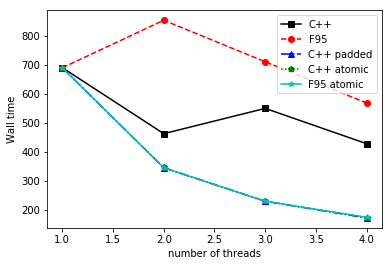

In [61]:
plt.plot(np.arange(1,5),cpres,marker='s',color='k',ls='-',label='C++')
plt.plot(np.arange(1,5),f95res,marker='o',color='r',ls='--',label='F95')
plt.plot(np.arange(1,5),cpres_2,marker='^',color='b',ls='-.',label='C++ padded')
plt.plot(np.arange(1,5),cpres_3,marker='p',color='g',ls=':',label='C++ atomic')
plt.plot(np.arange(1,5),f95res_2,marker='*',color='c',ls='-',label='F95 atomic')
plt.ylabel('Wall time')
plt.xlabel('number of threads')
plt.legend()

<a id="four"></a>

# 4 - Work and Data Sharing Constructs

How do you split up pathways through the code between threads within a team (worksharing)?
- Loop construct
- Single construct
- Master construct
- Sections construct
- Task construct

The Loop construct is by far the most widespread:

    #pragma omp parallel
    {
        #pragma omp for //
        for(int i=0; i < N; i++)
            do_something_with(i); //a private copy of the variable i is created for each thread
    }

or directly:
    
    #pragma omp parallel for
    for(int i=0; i < N; i++)
            do_something_with(i);

    !$OMP parallel do
    do i = 1,N
        do_something_with(i)
    end do
    !$OMP end parallel do

The **schedule** clause affects how loop iterations are mapped onto threads:  
- schedule(static [,chunk])  
    - Deal-out blocks of iterations of size “chunk” to each thread.  
- schedule(dynamic[,chunk])
    - Each thread grabs “chunk” iterations off a queue until all iterations have been handled.
- schedule(guided[,chunk])
    - Threads dynamically grab blocks of iterations. The size of the block starts large and shrinks down to size “chunk” as the calculation proceeds.
- schedule(runtime)
    - Schedule and chunk size taken from the OMP_SCHEDULE environment variable (or the runtime library).
- schedule(auto)
    - Schedule is left up to the runtime to choose (does not have to be any of the above).

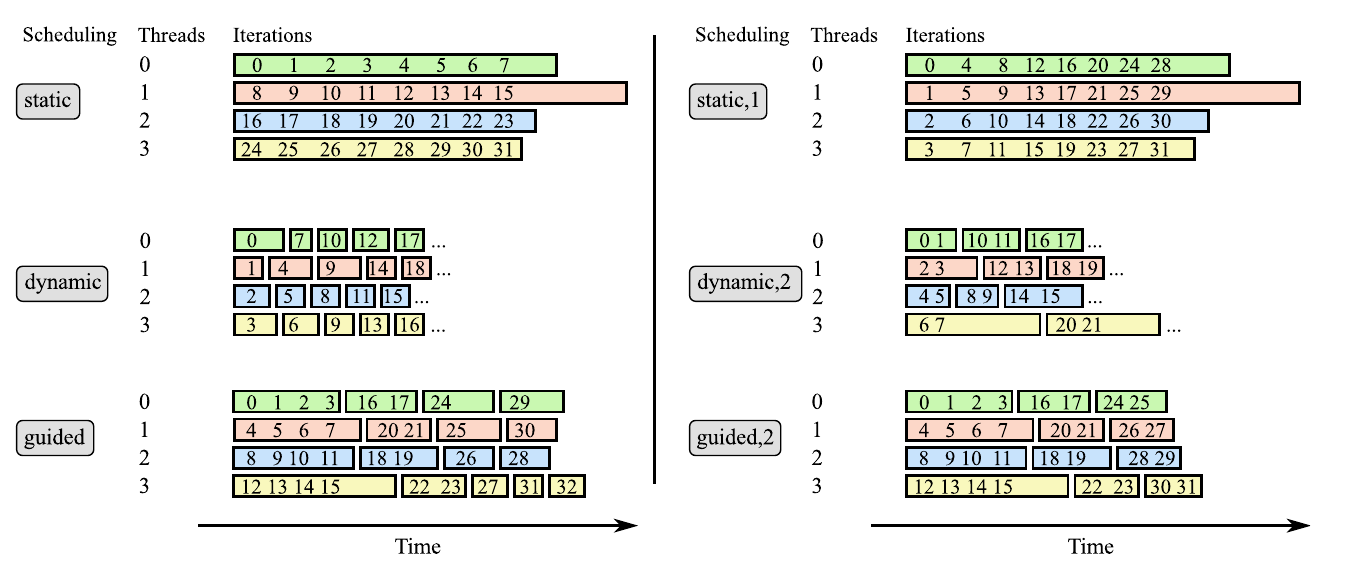

In [62]:
Image("omp_schedule.png")

We have seen how important is the temporary *promotion* of scalar variables to vectors. Can we automatise this?  

OpenMP **reduction** clause:
    reduction (op : list)
 
Inside a parallel or a work-sharing construct:
 - A local copy of each list variable is made and initialized depending on the “op” (e.g. 0 for “+”).
 - Updates occur on the local copy.
 - Local copies are reduced into a single value and combined with the original global value.
 - The variables in “list” must be shared in the enclosing parallel region.

    total = 0.;
    #pragma omp parallel for reduction (+:total)
    for(int i=0; i<N; i++)
        total += do_something_with(i);

The **Single** construct denotes a block of code that is executed by only one thread (not necessarily the master
thread). A barrier is implied at the end of the single block (can remove the barrier with a **nowait** clause).

    #pragma omp parallel
    {
        do_many_things();
        #pragma omp single nowait
        { 
            exchange_boundaries(); //one thread does this
        }
        do_many_other_things(); //the others start to do many other things
    }

    #pragma omp parallel
    {
        do_many_things();
        #pragma omp master // no implicit barrier as for single
        { 
            exchange_boundaries(); // the master thread does this
        }
        do_many_other_things(); // the others start to do many other things
    }

The **if** clause allows to select conditions for the execution of a directive:

    #pragma omp parallel for if(niter > nmin)

Therefore, a reduction is the way to go for our numerical integration (as you already know from the class on vectorization):

In [63]:
%%writefile integral_omp_red.cc
#include "integral.h"
int main(int argc, char **argv)
{
    
    const int num_steps = 1E8;
    const double start  = 0.;
    const double end    = 1.;
    
    double I  = 0.;
    const double dx = (end-start) / ((double ) num_steps);
    double t0 = omp_get_wtime();   
    
    #pragma omp parallel for reduction(+:I)
    for(int i=0; i < num_steps; i++)
    {
        double mid_x = start + dx * ((double ) i + 0.5);
        double mid_y = eval_func(mid_x);
        I += mid_y;
    }
    I = I * dx;
    double t1 = omp_get_wtime();
    
    std::cout  << "Loop completed in "<< 1000.*(t1-t0) << " ms using " << std::endl;
    std::cout  << "Integral value = " << I << std::endl;
}

Writing integral_omp_red.cc


In [64]:
%%bash
export LD_LIBRARY_PATH=/usr/local/gcc-7.3.0/lib64/:$LD_LIBRARY_PATH
make clean && make openmp_red mygcc=1
OMP_NUM_THREADS=2 ./integral.exe

rm -f integral*o eval_func*o integral.exe myodule.mod
/usr/local/gcc-7.3.0/bin/g++ -c -Wall -fopenmp -I/usr/local/gcc-7.3.0/include     integral_omp_red.cc -o integral_omp_red.o
/usr/local/gcc-7.3.0/bin/g++ -c -Wall -fopenmp -I/usr/local/gcc-7.3.0/include     eval_func.cc -o eval_func.o
/usr/local/gcc-7.3.0/bin/g++ -o integral.exe integral_omp_red.o eval_func.o -lm -fopenmp -L/usr/local/gcc-7.3.0/lib64
Loop completed in 1224.97 ms using 
Integral value = 3.14159


In [65]:
%%capture cpbench_4
%%bash
export LD_LIBRARY_PATH=/usr/local/gcc-7.3.0/lib64/:$LD_LIBRARY_PATH
make clean && make openmp_for opt=1 mygcc=1    
OMP_NUM_THREADS=1 ./integral.exe
OMP_NUM_THREADS=2 ./integral.exe
OMP_NUM_THREADS=3 ./integral.exe
OMP_NUM_THREADS=4 ./integral.exe

In [66]:
pat = re.compile(r'(Loop\scompleted\sin\s)(.+)\sms')
cpres_4 = pat.findall(cpbench_4.stdout) 
cpres_4 = np.array(list(map(lambda x:float(x[-1]),cpres_4)))

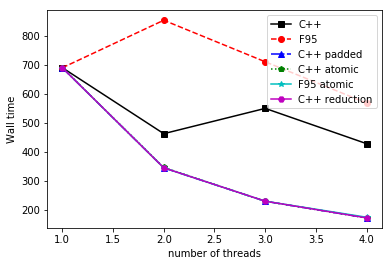

In [67]:
plt.plot(np.arange(1,5),cpres,marker='s',color='k',ls='-',label='C++')
plt.plot(np.arange(1,5),f95res,marker='o',color='r',ls='--',label='F95')
plt.plot(np.arange(1,5),cpres_2,marker='^',color='b',ls='-.',label='C++ padded')
plt.plot(np.arange(1,5),cpres_3,marker='p',color='g',ls=':',label='C++ atomic')
plt.plot(np.arange(1,5),f95res_2,marker='*',color='c',ls='-',label='F95 atomic')
plt.plot(np.arange(1,5),cpres_4,marker='H',color='m',label='C++ reduction')
plt.ylabel('Wall time')
plt.xlabel('number of threads')
plt.legend()

**beware**

note that Fortran is just the same: with private and default I do need a subroutine ...

- Shared Memory programming model:  
    - Most variables are shared by default  
    
- Global variables are **shared** among threads  
    - Fortran: COMMON blocks, SAVE variables, MODULE variables  
    - C/C++: File scope variables, static  
    - Both: dynamically allocated memory (ALLOCATE, malloc, new)  

- But not everything is shared:
    - Stack variables in subprograms(Fortran) or functions(C/C++) called from parallel regions are **private**

    double x = 0; //created outside the stack: shared
    double *A = calloc(sizeof(double),N); //dynamical allocation: shared
    #pragma omp parallel for private(x) //x changed to private
    for(int i; i<N; i++)
    {
        x = myfunc_1(i); //local variables to myfunc_1 private
        y = myfunc_2(x); //created in the stack: private
        A[i] += x+y;     //loop index private
    }

The dafult behaviour can be changed with the following clauses:

- private(variable list)
- shared(variable list)
- firstprivate(variable list): to transmit the variable's value from outside into the parallel region.
- lastprivate(variable list) : to transmit the variable's value from the parallel region to  outside (available only for certain constructs). 

In [68]:
%%writefile private_test.cc
#include <iostream>
#include <cstdio>
#include <omp.h>

int main ()
{
    int i = 10;
    float j = 10.;

    #pragma omp parallel private(i) firstprivate(j) 
    {
        int ID = omp_get_thread_num();
        printf("thread ID=%d i=%d j=%f\n",ID,i,j);
        i = 1000  + ID;
        j = 1000. + (float ) ID;
    }
    std::cout << "i, j = " << i << "  " << j << std::endl;
}

Writing private_test.cc


In [69]:
%%bash
source /usr/local/bin/gcc_vars.sh
g++ -Wall -fopenmp private_test.cc
OMP_NUM_THREADS=4 ./a.out

thread ID=0 i=0 j=10.000000
thread ID=3 i=0 j=10.000000
thread ID=1 i=32521 j=10.000000
thread ID=2 i=0 j=10.000000
i, j = 10  10


private_test.cc: In function 'main._omp_fn.0':
private_test.cc:13:15: warning: 'i' is used uninitialized in this function [-Wuninitialized]
         printf("thread ID=%d i=%d j=%f\n",ID,i,j);
         ~~~~~~^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
private_test.cc:7:9: note: 'i' was declared here
     int i = 10;
         ^


In [70]:
%%writefile private_test_2.cc
#include <iostream>
#include <cmath>
#include <omp.h>

int main ()
{
    float j = 10.;
    #pragma omp parallel for lastprivate(j) 
    for(int i=0; i < 1000; i++)
    {
        j = sin((float ) i);
    }
    std::cout << " j = " << j << std::endl;
}

Writing private_test_2.cc


In [71]:
%%bash
source /usr/local/bin/gcc_vars.sh
g++ -Wall -fopenmp private_test_2.cc
OMP_NUM_THREADS=4 ./a.out

 j = -0.0264608


**OpenMP** Environment variables:
 
- OMP_NUM_THREADS
- OMP_SCHEDULE (when using schedule(runtime)
- OMP_THREADLIMIT
- OMP_STACKSIZE

see also the [gcc documentation](#https://gcc.gnu.org/onlinedocs/libgomp/Environment-Variables.html)

**Thread affinity**

Variables `OMP_PLACES` and `OMP_CORES` define how threads are assigned to physical resources. Example: if you have two sockets and you define:

    OMP_PLACES=sockets  
    
then  
- thread 0 goes to socket 0,
- thread 1 goes to socket 1,
- thread 2 goes to socket 0 again,  
...

**Loop collapse**

The collapse clause (in OpenMP 3.0) handles perfectly nested multi-dimensional loops.   
Iteration space from `i-loop` and `j-loop` is collapsed into a single one, if the two loops are perfectly nested and form a rectangular iteration space. 	

    #pragma omp for collapse(2)
    for (i = 0; i < N; i++)
        for (j = 0; j < M; j++)
            for (k = 0; k < K; k++)f
                do_work(i, j, k);

**Conditional compilation**

statements to be compiled only when using **OpenMP** can included in macros using `_OPENMP`:

    #ifdef _OPENMP
    #pragma omp parallel
    {
        parallel_stuff();
    }
    #else
        serial_stuff();
    #endif

note that `_OPENMP` is a macro hence is available in Fortran:
    
    #ifdef _OPENMP
    !$OMP parallel
        call parallel_subroutine
!$OMP end parallel
    #else
        call serial_subrountine()
    #endif

<a id="five"></a>

# 5 - Tasks with OpenMP

**List traversal**

The worksharing `omp for` constructs requires the knowledge or the number of iterations at runtime. What if I have to parallelise a code like that:

    p = start;
    while (p)
    {
        process(p);
        p->p.next;
    }

**OpenMP Tasks**

- **Tasks** are independent units of work, composed of:  
    - code to execute.  
    - data environment.  
    - internal control variables (ICV).  

- It's natural than to map threads to tasks. The runtime system decides when tasks are executed:  
    - Tasks may be deferred.  
    - Tasks may be executed immediately.  

**List traversal with tasks**:

    #pragma omp parallel   // create a team of threads
    {
        #pragma omp single // BLOCK 1: only one threads continues, the others wait
        {
            p = start;
            while (p)      // BLOCK 2
            {
                #pragma omp task firstprivate(p) // BLOCK 3: create a task for unit of work used to process p
                    process(p);                  // use firstprivate to initialise the task
                p->p.next;
            }                                    // barrier for the single thread; threads waiting here
       }                                         // are assigned to taks by the runtime system
    }

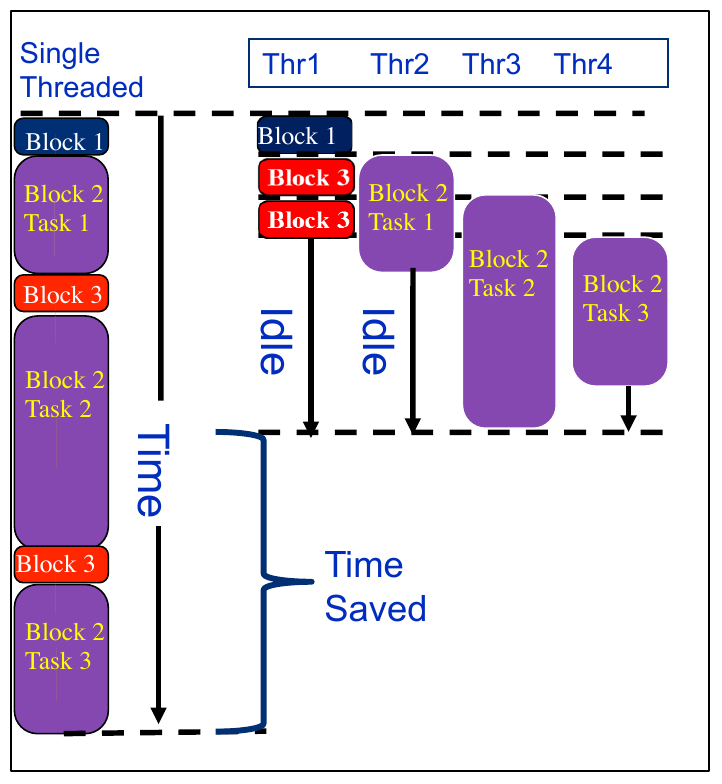

In [72]:
Image("tasks.png")

Task are completed at implicit or explicti barriers i. e.:
- `omp barrier` directive (thread barrier)
- closing of structured blocks (`{}`)
- `omp taskwait` directives (task barrier)

**Fibonacci sequence with tasks**

    int fib ( int n )                  // n is private between tasks when called recursively
    {
        int x,y;
        if ( n < 2 ) return n;
        #pragma omp task shared (x)
            x = fib(n-1);
         #pragma omp task shared(y)
            y = fib(n-2);
         #pragma omp taskwait      //  explicit task barrier
            return x+y;            //  if x and y weren't shared they would stay with the inizialitation value
    }

**Task**: a specific instance of executable code and its data environment.  
**Task region**: all the code encountered during the execution of a task.  

When a task construct is encountered by a thread, the generated task may be:  
- Deferred: executed by some thread independently of generating task.  
- Undeferred: completes execution before the generating task continues.  
- Included: Undeferred and executed by the thread that encounters the task construct.  

Let's try to use tasks to produce yet another version of our test case:

In [73]:
%%writefile integral_omp_task.cc
#include "integral.h"

double do_work(int min_size, int *first, int num_steps, double dx, double start)
{
    int tsize = std::min(num_steps - *first, min_size);
    double sum = 0.;
    
    for(int i = *first; i < *first + tsize; i++)
    {
        double mid_x = start + dx * ((double ) i + 0.5);
        sum += eval_func(mid_x);        
    }
    return sum;
}

int main(int argc, char **argv)
{
    const int frac = argv[1] != NULL ? atoi(argv[1]) : 1000;
    const int num_steps = 1E8;
    const int min_size  = num_steps / frac;
    const double start  = 0.;
    const double end    = 1.;
    
    double PI  = 0.;
    const double dx = (end-start) / ((double ) num_steps);
    int done = 0;
    double t0 = omp_get_wtime(); 

    #pragma omp parallel
    {
        #pragma omp single
        while (done < num_steps - min_size)
        {
            double sum = 0.;
            #pragma omp task shared(sum)
                sum = do_work(min_size, &done, num_steps, dx, start);    
            #pragma omp taskwait
            {
                PI += sum;
                done += min_size;
            }
        }
    } 

    PI = (PI + do_work(min_size, &done, num_steps+1, dx, start)) * dx;
    double t1 = omp_get_wtime();
    
    std::cout  << "Loop completed in "<< 1000.*(t1-t0) << " ms using " << std::endl;
    std::cout  << "Integral value = " << PI << std::endl;
}

Writing integral_omp_task.cc


In [74]:
%%bash
export LD_LIBRARY_PATH=/usr/local/gcc-7.3.0/lib64/:$LD_LIBRARY_PATH
make clean && make openmp_task mygcc=1
OMP_NUM_THREADS=2 ./integral.exe

rm -f integral*o eval_func*o integral.exe myodule.mod
/usr/local/gcc-7.3.0/bin/g++ -c -Wall -fopenmp -I/usr/local/gcc-7.3.0/include     integral_omp_task.cc -o integral_omp_task.o
/usr/local/gcc-7.3.0/bin/g++ -c -Wall -fopenmp -I/usr/local/gcc-7.3.0/include     eval_func.cc -o eval_func.o
/usr/local/gcc-7.3.0/bin/g++ -o integral.exe integral_omp_task.o eval_func.o -lm -fopenmp -L/usr/local/gcc-7.3.0/lib64	
Loop completed in 2096.07 ms using 
Integral value = 3.14159


In [75]:
%%bash
export LD_LIBRARY_PATH=/usr/local/gcc-7.3.0/lib64/:$LD_LIBRARY_PATH
make clean && make openmp_task opt=1 mygcc=1    
OMP_NUM_THREADS=1 ./integral.exe
OMP_NUM_THREADS=2 ./integral.exe
OMP_NUM_THREADS=3 ./integral.exe
OMP_NUM_THREADS=4 ./integral.exe

rm -f integral*o eval_func*o integral.exe myodule.mod
/usr/local/gcc-7.3.0/bin/g++ -c -Wall -fopenmp -O2 -I/usr/local/gcc-7.3.0/include     integral_omp_task.cc -o integral_omp_task.o
/usr/local/gcc-7.3.0/bin/g++ -c -Wall -fopenmp -O2 -I/usr/local/gcc-7.3.0/include     eval_func.cc -o eval_func.o
/usr/local/gcc-7.3.0/bin/g++ -o integral.exe integral_omp_task.o eval_func.o -lm -fopenmp -L/usr/local/gcc-7.3.0/lib64	
Loop completed in 690.514 ms using 
Integral value = 3.14159
Loop completed in 691.912 ms using 
Integral value = 3.14159
Loop completed in 691.603 ms using 
Integral value = 3.14159
Loop completed in 692.667 ms using 
Integral value = 3.14159


Why this poor scaling?

`omp taskwait` causes serialization. We need to make tasks more independent from each one.

**The Divide and Conquer design pattern**

Divide and conquer is an important design pattern with two distinct phases

- Divide phase:  
    - Breaks down problem into two or more sub-problems of the same (or related) type.  
    - Continue division until these sub-problems become simple enough to be solved directly.  
- Conquer phase:  
    - Executes the computations on each of the “indivisible” sub-problems.  
    - May also combine solutions of sub-problems until the solution of the original problem is reached.  

Implementation is typically done with recursive algorithms. Why?

- Because the nature of recursion forms smaller sub-problems that are very much like the larger problem being solved.  
- The return from recursive calls can be used to combine partial solutions into an overall solution.  

How to implement it?  
- Define a split operation
- Continue to split the problem until subproblems are small enough to solve directly (you fix a threshold).  
- Recombine solutions to subproblems to solve original global problem.  

the Fibonacci sequence with tasks is an example of the *Divide and Conquer* design pattern: we spit until a known value is returned then merge again.

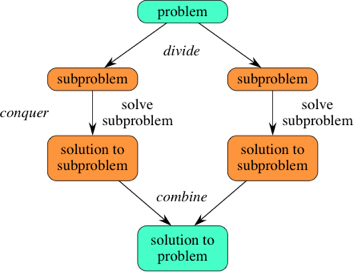

In [76]:
Image("dac.jpg")

## (Final ) Exercise 3

Write a final version of the exercise using Tasks and the *Divide and Conquer* design pattern. 

**Hint**

You need to define a split operation and set a sensible minimum of size fo your problem .

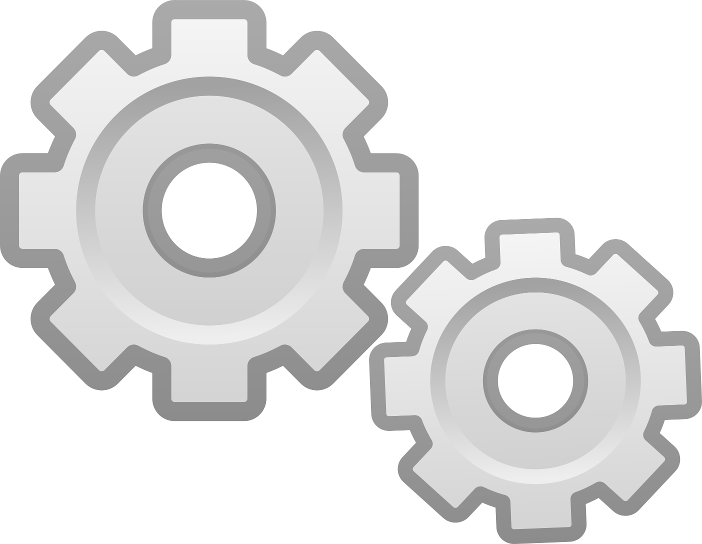

In [77]:
Image("gears.png")

In [83]:
%%writefile integral_omp_task_dac.cc
#include "integral.h"

double do_work(int first, int last, int min_size, double start, double dx)
{
    double sum = 0.;
    if(last - first < min_size)
    {
        for(int i = first; i < last; i++)
        {
            double mid_x = start + dx * ((double ) i + 0.5);
            double mid_y = eval_func(mid_x);
            sum += mid_y;
        }
    }
    else
    {
        int tsize = (last - first)/2;
        double sum1 = 0.;
        double sum2 = 0.;
        #pragma omp task shared(sum1)
        sum1 = do_work(first, first+tsize, min_size, start, dx);
        #pragma omp task shared(sum2)
        sum2 = do_work(first+tsize, last, min_size, start, dx);
        #pragma omp taskwait
        sum = sum1 + sum2;
    }
    return sum;
}

int main(int argc, char **argv)
{
    
    const int num_steps = 1E8;
    const double start  = 0.;
    const double end    = 1.;
    
    double I  = 0.;
    const double dx = (end-start) / ((double ) num_steps);
    double t0 = omp_get_wtime(); 
    int min_size = num_steps / 10;
    #pragma omp parallel
    {
        #pragma omp single
        I += do_work(0, num_steps, min_size, start, dx);
    } 
    double t1 = omp_get_wtime();
    I *= dx;
    
    std::cout  << "Loop completed in "<< 1000.*(t1-t0) << " ms using " << std::endl;
    std::cout  << "Integral value = " << I << std::endl;
}

Overwriting integral_omp_task_dac.cc


In [84]:
%%bash
export LD_LIBRARY_PATH=/usr/local/gcc-7.3.0/lib64/:$LD_LIBRARY_PATH
make clean && make openmp_task_dac mygcc=1
OMP_NUM_THREADS=2 ./integral.exe

rm -f integral*o eval_func*o integral.exe myodule.mod
/usr/local/gcc-7.3.0/bin/g++ -c -Wall -fopenmp -I/usr/local/gcc-7.3.0/include     integral_omp_task_dac.cc -o integral_omp_task_dac.o
/usr/local/gcc-7.3.0/bin/g++ -c -Wall -fopenmp -I/usr/local/gcc-7.3.0/include     eval_func.cc -o eval_func.o
/usr/local/gcc-7.3.0/bin/g++ -o integral.exe integral_omp_task_dac.o eval_func.o -lm -fopenmp -L/usr/local/gcc-7.3.0/lib64	    
Loop completed in 1208.61 ms using 
Integral value = 3.14159


In [85]:
%%capture cpbench_5
%%bash
export LD_LIBRARY_PATH=/usr/local/gcc-7.3.0/lib64/:$LD_LIBRARY_PATH
make clean && make openmp_task_dac opt=1 mygcc=1    
OMP_NUM_THREADS=1 ./integral.exe
OMP_NUM_THREADS=2 ./integral.exe
OMP_NUM_THREADS=3 ./integral.exe
OMP_NUM_THREADS=4 ./integral.exe

In [86]:
pat = re.compile(r'(Loop\scompleted\sin\s)(.+)\sms')
cpres_5 = pat.findall(cpbench_5.stdout) 
cpres_5 = np.array(list(map(lambda x:float(x[-1]),cpres_5)))

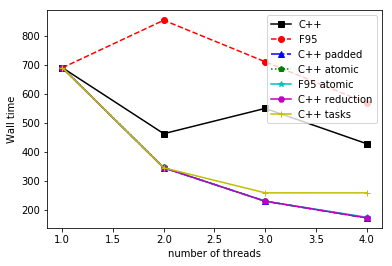

In [87]:
plt.plot(np.arange(1,5),cpres,marker='s',color='k',ls='-',label='C++')
plt.plot(np.arange(1,5),f95res,marker='o',color='r',ls='--',label='F95')
plt.plot(np.arange(1,5),cpres_2,marker='^',color='b',ls='-.',label='C++ padded')
plt.plot(np.arange(1,5),cpres_3,marker='p',color='g',ls=':',label='C++ atomic')
plt.plot(np.arange(1,5),f95res_2,marker='*',color='c',ls='-',label='F95 atomic')
plt.plot(np.arange(1,5),cpres_4,marker='H',color='m',label='C++ reduction')
plt.plot(np.arange(1,5),cpres_5,marker='+',color='y',label='C++ tasks')
plt.ylabel('Wall time')
plt.xlabel('number of threads')
plt.legend()

<a id="six"></a>

# Conclusions

We are now to scale *whitin a single core* (with *vectorization*) and within a *single NUMA machine* (with *OpenMP*).  
The next steps:

- go outside the sockets: multiple nodes.
- go outside the sockets: PCI/E interface -> accellerators.

Some of the topics not covered:
     
- Advanced Tasking
- Locks
- Flush
- Offload to accellerators with OpenMP
- Less Common functions and environment variables

## References:

Nothing easier than looking on the [website](#https://www.openmp.org/resources/openmp-books/).  
See also the [Lawrence Livermore Lab. page on OpenMP](#https://computing.llnl.gov/tutorials/openMP/).